## 1. Import thư viện

In [841]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from catboost import CatBoostRegressor
import shap
import os
import scipy.stats as stats


## 2. Thu thập và đọc dữ liệu


### 2.1 đọc file csv

In [ ]:
# Đọc dữ liệu từ file CSV
data = pd.read_csv('StudentsPerformance.csv')

# Hiển thị thông tin tổng quát về dữ liệu
data.info()
a
# Hiển thị 5 dòng đầu tiên của dữ liệu
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


### 2.2 kiểm tra dữ liệu

In [843]:
## kiểm tra giá trị trùng lặp
data.duplicated().sum()
## kiểm tra giá trị null
data.isnull().sum()

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

## 3.Khám phá dữ liệu (EDA) & trực quan hóa

### 3.1 phân tích mối quan hệ giới tính và điểm trung bình

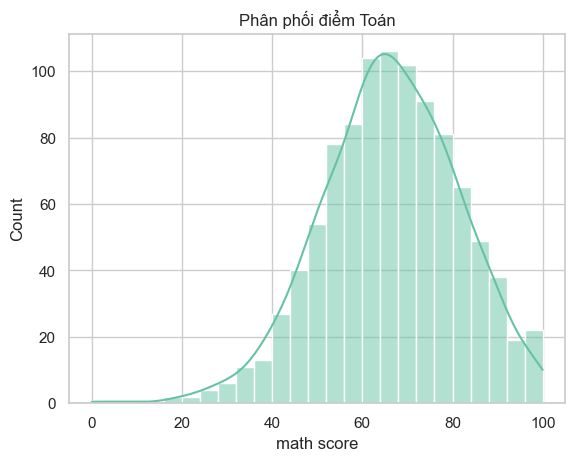

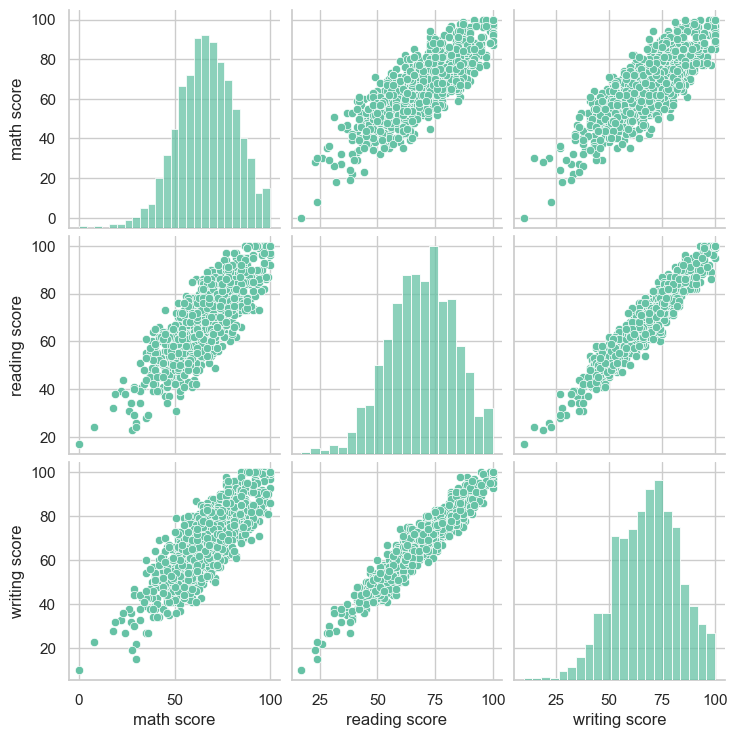

In [844]:
# Histogram
sns.histplot(data['math score'], kde=True)
plt.title("Phân phối điểm Toán")
plt.show()

# Pairplot
sns.pairplot(data)
plt.show()


### Kết luận: Các điểm số có xu hướng phân phối đều

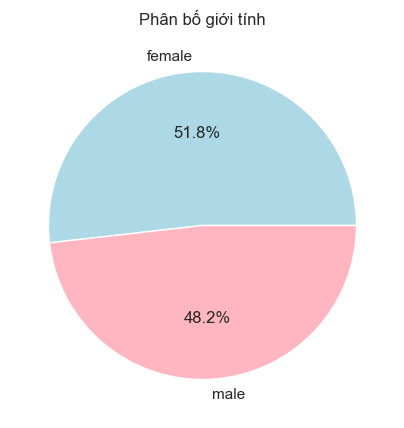

In [845]:
# Pie chart
data['gender'].value_counts().plot.pie(
    autopct='%1.1f%%',
    colors=['lightblue', 'lightpink'],
    figsize=(5,5),
    ylabel='',
    title='Phân bố giới tính'
)
plt.show()

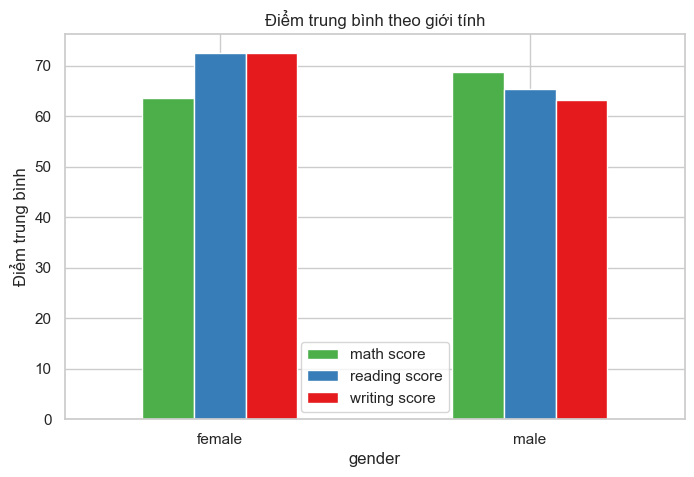

In [846]:
avg_scores = data.groupby('gender')[['math score', 'reading score', 'writing score']].mean()
avg_scores.plot(kind='bar', figsize=(8,5), color=['#4DAF4A', '#377EB8', '#E41A1C'])
plt.title("Điểm trung bình theo giới tính")
plt.ylabel("Điểm trung bình")
plt.xticks(rotation=0)
plt.show()

### biểu đồ cho thấy
- Nữ sinh (female) có điểm đọc (reading) và viết (writing) cao hơn rõ rệt so với nam.

- Nam sinh (male) lại nhỉnh hơn ở môn Toán (math).

### 3.2 phân tích mối quan hệ chủng tộc và điểm

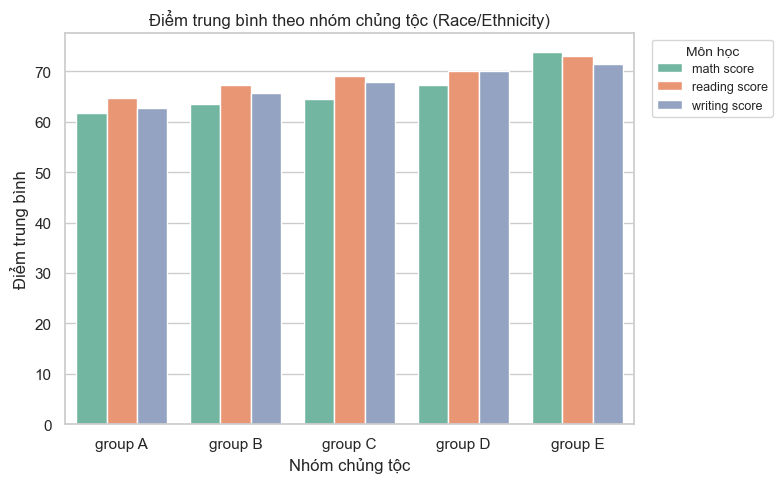

In [847]:
# Gộp dữ liệu theo race và tính điểm trung bình
avg_race = data.groupby('race/ethnicity')[['math score', 'reading score', 'writing score']].mean().reset_index()

# Chuyển từ dạng wide sang long (để seaborn dễ vẽ)
avg_race_melted = pd.melt(
    avg_race,
    id_vars='race/ethnicity',
    var_name='subject',
    value_name='average_score'
)

# Vẽ biểu đồ
plt.figure(figsize=(8,5))
sns.barplot(data=avg_race_melted, x='race/ethnicity', y='average_score', hue='subject')
plt.title("Điểm trung bình theo nhóm chủng tộc (Race/Ethnicity)")
plt.xlabel("Nhóm chủng tộc")
plt.ylabel("Điểm trung bình")
plt.legend(
    title='Môn học',
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    fontsize=9,
    title_fontsize=10
)
plt.tight_layout()
plt.show()

### kết luận: 
- Điểm trung bình của học sinh tăng dần từ nhóm A → E.
- Nhóm E có điểm cao nhất ở cả ba môn (Math, Reading, Writing), trong khi nhóm A thấp nhất.
- Điều này cho thấy chủng tộc có ảnh hưởng nhất định đến thành tích học tập, có thể do khác biệt về điều kiện giáo dục hoặc kinh tế - xã hội.

### 3.3 phân tích mối quan hệ trình độ học vấn cha mẹ và điểm 

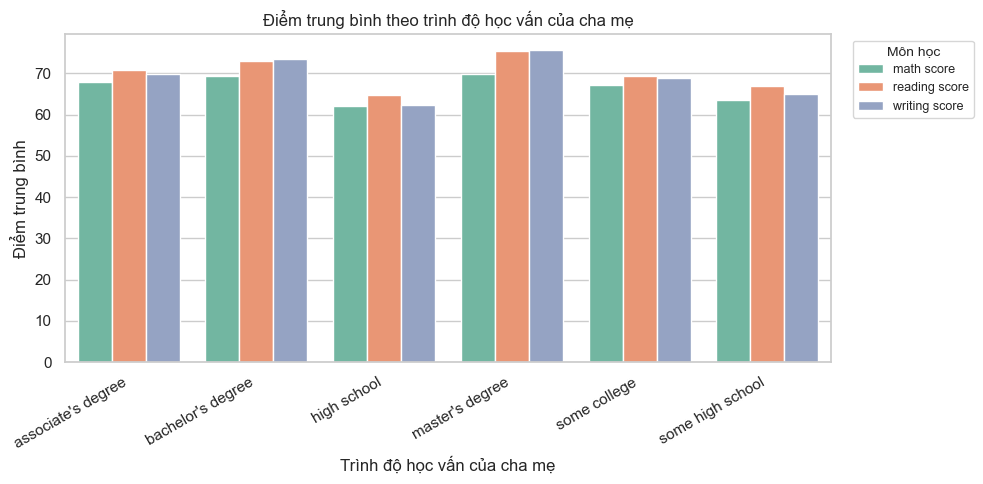

In [848]:
# Trình độ cha mẹ vs điểm
avg_parent = data.groupby('parental level of education')[['math score','reading score','writing score']].mean().reset_index()
avg_parent_melt = pd.melt(avg_parent, id_vars='parental level of education',
                          var_name='subject', value_name='average_score')

plt.figure(figsize=(10,5))
sns.barplot(data=avg_parent_melt, x='parental level of education', y='average_score', hue='subject')
plt.title("Điểm trung bình theo trình độ học vấn của cha mẹ")
plt.xticks(rotation=30, ha='right')
plt.xlabel("Trình độ học vấn của cha mẹ")
plt.ylabel("Điểm trung bình")
plt.legend(
    title='Môn học',
    bbox_to_anchor=(1.02, 1),   # đẩy ra khỏi khung vẽ
    loc='upper left',
    fontsize=9,
    title_fontsize=10
)
plt.tight_layout()
plt.show()


### kết luận
- Học sinh có cha mẹ đạt trình độ bachelor’s degree hoặc master’s degree thường có điểm trung bình cao nhất ở cả ba môn.
- Ngược lại, học sinh có cha mẹ chỉ học đến high school hoặc some high school có kết quả thấp hơn rõ rệt.

Điều này chứng tỏ trình độ học vấn của phụ huynh ảnh hưởng tích cực đến thành tích học tập của con.

### 3.4 phân tích mối quan hệ điểm trung bình theo tình trạng chuẩn bị kiểm tra (test preparation course)

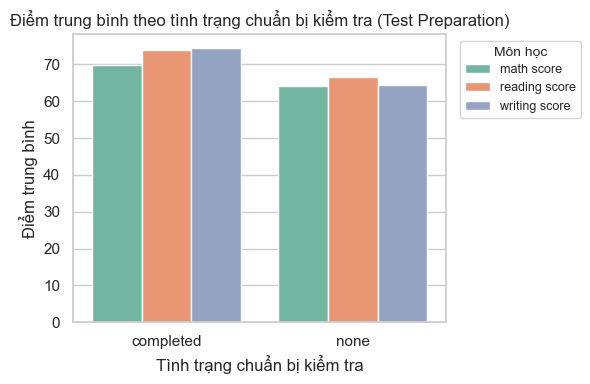

In [849]:
# Gộp dữ liệu và chuyển dạng long
avg_test = data.groupby('test preparation course')[['math score','reading score','writing score']].mean().reset_index()
avg_test_melt = pd.melt(avg_test, id_vars='test preparation course', var_name='subject', value_name='average_score')

# Vẽ biểu đồ
plt.figure(figsize=(6,4))
sns.barplot(data=avg_test_melt, x='test preparation course', y='average_score', hue='subject')

plt.title("Điểm trung bình theo tình trạng chuẩn bị kiểm tra (Test Preparation)")
plt.xlabel("Tình trạng chuẩn bị kiểm tra")
plt.ylabel("Điểm trung bình")

# Legend nhỏ, ra ngoài
plt.legend(
    title='Môn học',
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    fontsize=9,
    title_fontsize=10
)
plt.tight_layout()
plt.show()


### kết luận:

- Nhóm học sinh đã hoàn thành khóa chuẩn bị kiểm tra (completed) có điểm trung bình cao hơn nhóm chưa ôn luyện (none) ở cả ba môn.

- Điều này khẳng định rằng việc ôn tập có tổ chức trước kỳ thi giúp cải thiện rõ rệt kết quả học tập.

### 3.5 phân tích mối quan hệ điểm trung bình theo bữa ăn (lunch)

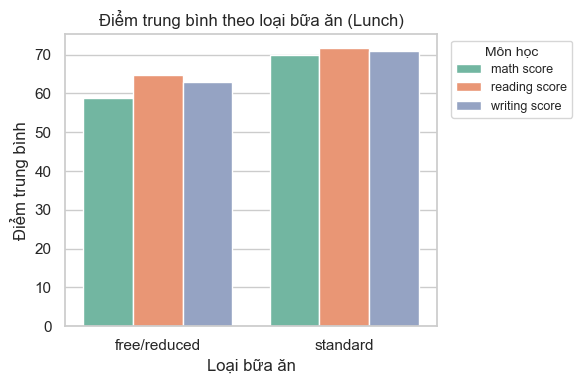

In [850]:
# Gộp dữ liệu và chuyển dạng long
avg_lunch = data.groupby('lunch')[['math score','reading score','writing score']].mean().reset_index()
avg_lunch_melt = pd.melt(avg_lunch, id_vars='lunch', var_name='subject', value_name='average_score')

# Vẽ biểu đồ
plt.figure(figsize=(6,4))
sns.barplot(data=avg_lunch_melt, x='lunch', y='average_score', hue='subject')

plt.title("Điểm trung bình theo loại bữa ăn (Lunch)")
plt.xlabel("Loại bữa ăn")
plt.ylabel("Điểm trung bình")

# Legend nhỏ, ra ngoài
plt.legend(
    title='Môn học',
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    fontsize=9,
    title_fontsize=10
)
plt.tight_layout()
plt.show()


### kết luận: 
- Học sinh được hưởng bữa ăn tiêu chuẩn (standard) đạt điểm trung bình cao hơn so với nhóm free/reduced lunch ở tất cả các môn học.
- điều kiện dinh dưỡng và kinh tế có thể tác động đáng kể đến hiệu quả học tập của học sinh.

## Kết luận chung:

- Tổng hợp các phân tích cho thấy các yếu tố nhân khẩu học và điều kiện cá nhân (giới tính, chủng tộc, học vấn cha mẹ, dinh dưỡng, chuẩn bị thi) đều có mối liên hệ đáng kể với điểm số học sinh.

- Trong đó, học vấn cha mẹ và tình trạng chuẩn bị kiểm tra là hai yếu tố ảnh hưởng mạnh nhất, phản ánh vai trò của giáo dục gia đình và thói quen học tập chủ động trong việc cải thiện thành tích học tập.

## 4. Tiền xử lý dữ liệu (Preprocessing)

#### 4.1 Chuẩn hóa tên cột

In [851]:
# Chuẩn hóa tên cột: bỏ khoảng trắng, chuyển thành chữ thường
data.columns = data.columns.str.strip().str.replace(' ', '_').str.lower()
data.head()

,gender,race/ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


### 4.2 Kiểm tra trùng lặp và giá trị thiếu

In [852]:
# Kiểm tra trùng lặp
duplicate_count = data.duplicated().sum()
print("Số dòng trùng lặp:", duplicate_count)

# Kiểm tra giá trị bị thiếu (NaN)
missing_values = data.isnull().sum()
print("\nSố giá trị thiếu mỗi cột:\n", missing_values)


Số dòng trùng lặp: 0

Số giá trị thiếu mỗi cột:
 gender                         0
race/ethnicity                 0
parental_level_of_education    0
lunch                          0
test_preparation_course        0
math_score                     0
reading_score                  0
writing_score                  0
dtype: int64


### 4.3 Mã hóa dữ liệu phân loại (Categorical Encoding)

In [853]:
data = data.rename(columns={
    'race/ethnicity': 'race_ethnicity',
    'parental_level_of_education': 'parental_level_of_education',
    'test_preparation_course': 'test_preparation_course',
    'math_score': 'math_score',
    'reading_score': 'reading_score',
    'writing_score': 'writing_score'
})

#  Chuẩn hóa giá trị (lowercase + strip) trước khi map để tránh lệch chữ hoa/thường
for col in ['gender','lunch','test_preparation_course','race_ethnicity','parental_level_of_education']:
    data[col] = data[col].astype(str).str.strip().str.lower()

#  Định nghĩa mapping đúng như bạn yêu cầu
gender_map = {'male': 1, 'female': 0}
lunch_map = {'standard': 1, 'free/reduced': 0}
test_prep_map = {'none': 0, 'completed': 1}
race_map = {'group a': 0, 'group b': 1, 'group c': 2, 'group d': 3, 'group e': 4}
parent_map = {
    'some high school': 0,
    'high school': 1,
    'some college': 2,
    "associate's degree": 3,
    "bachelor's degree": 4,
    "master's degree": 5
}

#  Áp dụng mapping
data['gender'] = data['gender'].map(gender_map)
data['lunch'] = data['lunch'].map(lunch_map)
data['test_preparation_course'] = data['test_preparation_course'].map(test_prep_map)
data['race_ethnicity'] = data['race_ethnicity'].map(race_map)
data['parental_level_of_education'] = data['parental_level_of_education'].map(parent_map)

# Kiểm tra xem còn giá trị nào chưa được map (NaN) không
check_cols = ['gender','lunch','test_preparation_course','race_ethnicity','parental_level_of_education']
for c in check_cols:
    n_unmapped = data[c].isna().sum()
    if n_unmapped > 0:
        print(f"⚠️ Cột {c} còn {n_unmapped} giá trị chưa map. Xem các giá trị khác biệt:")
        print(data.loc[data[c].isna(), c].head())


#  Đổi kiểu về int (nếu cần)
for c in check_cols:
    data[c] = data[c].astype('int64')

data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   gender                       1000 non-null   int64
 1   race_ethnicity               1000 non-null   int64
 2   parental_level_of_education  1000 non-null   int64
 3   lunch                        1000 non-null   int64
 4   test_preparation_course      1000 non-null   int64
 5   math_score                   1000 non-null   int64
 6   reading_score                1000 non-null   int64
 7   writing_score                1000 non-null   int64
dtypes: int64(8)
memory usage: 62.6 KB


### kết quả mã hóa:
- gender: female -> 0, male -> 1
- lunch: standard -> 1, free/reduced -> 0
- test_preparation_course: none -> 0, completed -> 1
- race/ethnicity: group A -> 0, group B -> 1, group C -> 2, group D -> 3, group E -> 4 
- parental level of education: some high school = 0, high school = 1, some college = 2, associate’s degree = 3, bachelor’s degree = 4, master’s degree = 5. 

### 4.4 Tạo biến tổng hợp (Feature Engineering)

In [854]:
# Thêm cột tổng điểm và điểm trung bình
data['total_score'] = data['math_score'] + data['reading_score'] + data['writing_score']
data['average_score'] = data['total_score'] / 3

data[['math_score', 'reading_score', 'writing_score', 'total_score', 'average_score']].head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   gender                       1000 non-null   int64  
 1   race_ethnicity               1000 non-null   int64  
 2   parental_level_of_education  1000 non-null   int64  
 3   lunch                        1000 non-null   int64  
 4   test_preparation_course      1000 non-null   int64  
 5   math_score                   1000 non-null   int64  
 6   reading_score                1000 non-null   int64  
 7   writing_score                1000 non-null   int64  
 8   total_score                  1000 non-null   int64  
 9   average_score                1000 non-null   float64
dtypes: float64(1), int64(9)
memory usage: 78.3 KB


In [855]:
data.head(10)

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score,total_score,average_score
0,0,1,4,1,0,72,72,74,218,72.666667
1,0,2,2,1,1,69,90,88,247,82.333333
2,0,1,5,1,0,90,95,93,278,92.666667
3,1,0,3,0,0,47,57,44,148,49.333333
4,1,2,2,1,0,76,78,75,229,76.333333
5,0,1,3,1,0,71,83,78,232,77.333333
6,0,1,2,1,1,88,95,92,275,91.666667
7,1,1,2,0,0,40,43,39,122,40.666667
8,1,3,1,0,1,64,64,67,195,65.000000
9,0,1,1,0,0,38,60,50,148,49.333333


### 4.5 phân tích mối tương quan giữ total score với average score

In [856]:
# Phân tích thống kê mô tả
data.describe()


,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score,total_score,average_score
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.482000,2.174000,2.081000,0.645000,0.358000,66.08900,69.169000,68.054000,203.312000,67.770667
std,0.499926,1.157179,1.460333,0.478753,0.479652,15.16308,14.600192,15.195657,42.771978,14.257326
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,17.000000,10.000000,27.000000,9.000000
25%,0.000000,1.000000,1.000000,0.000000,0.000000,57.00000,59.000000,57.750000,175.000000,58.333333
50%,0.000000,2.000000,2.000000,1.000000,0.000000,66.00000,70.000000,69.000000,205.000000,68.333333
75%,1.000000,3.000000,3.000000,1.000000,1.000000,77.00000,79.000000,79.000000,233.000000,77.666667
max,1.000000,4.000000,5.000000,1.000000,1.000000,100.00000,100.000000,100.000000,300.000000,100.000000


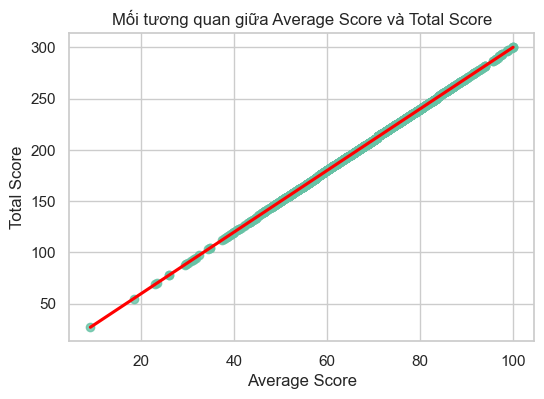

Hệ số tương quan Pearson giữa total_score và average_score: 1.0000


In [857]:
# Biểu đồ scatter và đường hồi quy giữa total_score và average_score
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.regplot(x='average_score', y='total_score', data=data, line_kws={'color':'red'})
plt.title('Mối tương quan giữa Average Score và Total Score')
plt.xlabel('Average Score')
plt.ylabel('Total Score')
plt.show()


# Hệ số tương quan Pearson
corr = data['total_score'].corr(data['average_score'])
print(f"Hệ số tương quan Pearson giữa total_score và average_score: {corr:.4f}")



### 4.6 Kiểm định ANOVA (Analysis of Variance)

#### kiểm định giả thuyết
- H0 (Null Hypothesis): Không có sự khác biệt đáng kể về tổng điểm (total_score) giữa các nhóm của thuộc tính.

- H1 (Alternative Hypothesis): Có sự khác biệt đáng kể → thuộc tính có ảnh hưởng tới kết quả học tập.

Nếu p-value < 0.05, bác bỏ H₀ → thuộc tính đó có ảnh hưởng có ý nghĩa thống kê và nên giữ lại cho mô hình.

In [858]:
# Kiểm tra lại các cột phân loại
categorical_cols = ['gender', 'race_ethnicity', 'parental_level_of_education', 'lunch', 'test_preparation_course']

# Tạo biến phụ thuộc
target = 'total_score'

# Lưu kết quả kiểm định
anova_results = []

for col in categorical_cols:
    # Lấy nhóm giá trị của mỗi biến
    groups = [data[target][data[col] == level] for level in data[col].unique()]
    
    # Thực hiện kiểm định ANOVA một chiều
    f_stat, p_value = stats.f_oneway(*groups)
    
    anova_results.append({
        'Thuộc tính': col,
        'F-statistic': f_stat,
        'p-value': p_value
    })

anova_df = pd.DataFrame(anova_results)
anova_df


,Thuộc tính,F-statistic,p-value
0,gender,17.388179,3.311974e-05
1,race_ethnicity,9.096052,3.225869e-07
2,parental_level_of_education,10.753147,4.381046e-10
3,lunch,91.682790,7.736792e-21
4,test_preparation_course,70.407949,1.633780e-16


C:\Users\krizb\AppData\Local\Temp\ipykernel_7212\3297175506.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=anova_df, x='Thuộc tính', y='F-statistic', palette='viridis')


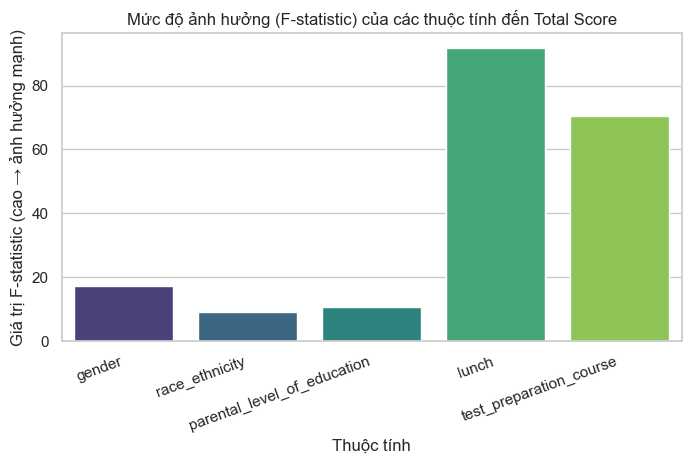

In [859]:
# Vẽ biểu đồ F-statistic
plt.figure(figsize=(8,4))
sns.barplot(data=anova_df, x='Thuộc tính', y='F-statistic', palette='viridis')
plt.title("Mức độ ảnh hưởng (F-statistic) của các thuộc tính đến Total Score")
plt.ylabel("Giá trị F-statistic (cao → ảnh hưởng mạnh)")
plt.xlabel("Thuộc tính")
plt.xticks(rotation=20, ha='right')
plt.show()


### Kết luận: 
- Dựa trên kết quả ANOVA, hai yếu tố có ảnh hưởng mạnh nhất đến kết quả học tập (total score) là:
(1) loại bữa ăn (lunch) và (2) tình trạng chuẩn bị kiểm tra (test_preparation_course).

- Điều này phù hợp với lý thuyết trong PDF (Section 3.6), khi hai yếu tố này được xác định là có tác động trực tiếp đến khả năng học tập và kết quả thi cử của học sinh.

In [860]:
 ## KIỂM TRA DỮ LIỆU 
print("\nKiểu dữ liệu sau khi tiền xử lý:")
print(data.dtypes)


Kiểu dữ liệu sau khi tiền xử lý:
gender                           int64
race_ethnicity                   int64
parental_level_of_education      int64
lunch                            int64
test_preparation_course          int64
math_score                       int64
reading_score                    int64
writing_score                    int64
total_score                      int64
average_score                  float64
dtype: object


In [861]:
data.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score,total_score,average_score
0,0,1,4,1,0,72,72,74,218,72.666667
1,0,2,2,1,1,69,90,88,247,82.333333
2,0,1,5,1,0,90,95,93,278,92.666667
3,1,0,3,0,0,47,57,44,148,49.333333
4,1,2,2,1,0,76,78,75,229,76.333333


## 5. Chia dữ liệu và Huấn luyện mô hình (Model Training)

### 5.1 Chia dữ liệu huẩn luyện và kiểm thử

In [ ]:

# Xác định biến độc lập và phụ thuộc
X = data.drop(columns=['math_score','reading_score','writing_score','total_score','average_score'])
y = data['average_score']

# Chia dữ liệu train/test (70% train – 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print("Kích thước tập huấn luyện:", X_train.shape)
print("Kích thước tập kiểm thử:", X_test.shape)


Kích thước tập huấn luyện: (700, 5)
Kích thước tập kiểm thử: (300, 5)


### 5.2 Khởi tạo và huẩn luyện 8 mô hình hồi quy

In [863]:
# Tập hợp mô hình
models = {
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Lasso": Lasso(alpha=0.1),
    "KNN": KNeighborsRegressor(),
    "AdaBoost": AdaBoostRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(random_state=42, n_estimators=200, learning_rate=0.1),
    "CatBoost": CatBoostRegressor(verbose=0, random_state=42)
}

# Huấn luyện và đánh giá từng mô hình
results = []

n = len(y_test)          # số mẫu kiểm thử
p = X_train.shape[1]     # số biến độc lập

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Tính Adjusted R²
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    
    results.append([name, mae, mse, rmse, r2 * 100, adj_r2 * 100])  # nhân 100 để ra %
   
# Tạo DataFrame kết quả
results_df = pd.DataFrame(results, columns=['Model', 'MAE', 'MSE', 'RMSE', 'R² (%)', 'Adj R² (%)'])
results_df = results_df.sort_values(by='R² (%)', ascending=False).reset_index(drop=True)

# Hiển thị kết quả
results_df

,Model,MAE,MSE,RMSE,R² (%),Adj R² (%)
0,Lasso,10.393287,171.311782,13.088613,24.008107,22.715727
1,AdaBoost,10.624239,179.088658,13.382401,20.558376,19.207328
2,Gradient Boosting,10.988358,191.156918,13.825951,15.205038,13.762946
3,KNN,11.587333,210.194533,14.498087,6.760175,5.174464
4,Random Forest,12.147577,229.793159,15.158930,-1.933545,-3.667109
5,CatBoost,12.148170,231.905562,15.228446,-2.870582,-4.620082
6,XGBoost,12.364364,239.440854,15.473877,-6.213150,-8.019496
7,Decision Tree,12.560369,244.926066,15.650114,-8.646325,-10.494052


### 5.3 So sánh hiệu suất mô hình 

C:\Users\krizb\AppData\Local\Temp\ipykernel_7212\2607246265.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Model', y='Adj R² (%)', palette='mako')


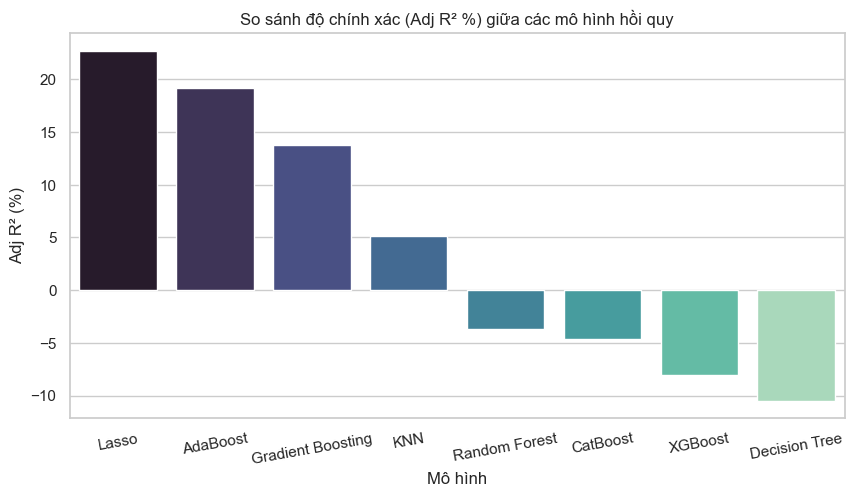

In [864]:
# Vẽ biểu đồ so sánh R² giữa các mô hình
plt.figure(figsize=(10,5))
sns.barplot(data=results_df, x='Model', y='Adj R² (%)', palette='mako')
plt.title("So sánh độ chính xác (Adj R² %) giữa các mô hình hồi quy")
plt.ylabel("Adj R² (%)")
plt.xlabel("Mô hình")
plt.xticks(rotation=10)
plt.show()

### 5.4 Kết luận mô hình tốt nhất

In [865]:
best = results_df.iloc[0]
print(f"Mô hình tốt nhất: {best['Model']}")
print(f"R² = {best['R² (%)']:.6f} %, Adj R² = {best['Adj R² (%)']:.6f} %,  MAE = {best['MAE']:.4f},  RMSE = {best['RMSE']:.4f}")

Mô hình tốt nhất: Lasso
R² = 24.008107 %, Adj R² = 22.715727 %,  MAE = 10.3933,  RMSE = 13.0886
